In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
from theano import shared
from sklearn.metrics import r2_score
import seaborn as sns

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

In [2]:
FM = pd.read_csv('Hawe_Guggisberg_All_0325.csv',sep=',', skipinitialspace=True)
np.shape(FM)

(489, 3)

In [3]:
FM = FM[(FM["TP1"]<45)]
np.shape(FM)

(359, 3)

In [4]:
FM["Group"] = np.zeros(len(FM))
FM["Group"].loc[FM["TP1"]>10] = 1

study_names = FM.Group.unique()
study_idx = FM.Group.values
study_idx = study_idx.astype(int)
n_studies = len(FM.Group.unique())

study_names_2 = FM.Study.unique()
study_idx_2 = FM.Study.values
study_idx_2 = study_idx_2.astype(int)
n_studies_2 = len(FM.Study.unique())

In [5]:
with pm.Model() as hierarchical_linear_model:
    
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=20)
    sigma_a = pm.HalfCauchy('sigma_a', 20)
    mu_a2 = pm.Normal('mu_a2', mu=0., sd=5)
    sigma_a2 = pm.HalfCauchy('sigma_a2', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)


    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_studies)
    a2 = pm.Normal('a2', mu=mu_a2, sd=sigma_a2, shape=n_studies_2)
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_studies)

    # Model error
    eps = pm.HalfCauchy('eps', 20)

    FM_est = a2[study_idx_2] + a[study_idx] + b[study_idx] * FM.TP1

    # Data likelihood
    FM_like = pm.Normal('FM_like', mu=FM_est, sd=eps, observed=FM.TP2)

In [6]:
with hierarchical_linear_model:
    hierarchical_linear_trace = pm.sample(draws=2000, n_init=1000, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, a2, a, sigma_b, mu_b, sigma_a2, mu_a2, sigma_a, mu_a]
Sampling 4 chains, 26 divergences: 100%|██████████| 10000/10000 [00:22<00:00, 311.62draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [7]:
pm.summary(hierarchical_linear_trace).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,13.02,14.40,-15.00,39.06,0.23,0.16,3915.0,3915.0,4080.0,4545.0,1.0
mu_a2,0.65,5.01,-9.04,9.76,0.12,0.09,1704.0,1704.0,1705.0,2712.0,1.0
mu_b,1.15,2.12,-3.19,5.19,0.04,0.03,3116.0,2514.0,3862.0,2560.0,1.0
a[0],8.18,5.64,-2.91,18.24,0.13,0.09,1818.0,1818.0,1817.0,2983.0,1.0
a[1],37.78,6.27,25.69,49.38,0.14,0.10,1938.0,1938.0,1935.0,2603.0,1.0
a2[0],-0.59,5.71,-11.77,9.49,0.13,0.09,1836.0,1836.0,1834.0,2697.0,1.0
a2[1],0.28,5.52,-10.29,10.44,0.13,0.09,1783.0,1783.0,1783.0,2997.0,1.0
a2[2],-3.17,5.51,-13.32,7.58,0.13,0.09,1773.0,1773.0,1773.0,2347.0,1.0
a2[3],6.03,5.46,-4.06,16.49,0.13,0.09,1692.0,1692.0,1693.0,2693.0,1.0
a2[4],1.57,5.76,-8.82,13.04,0.13,0.10,1847.0,1847.0,1847.0,3159.0,1.0


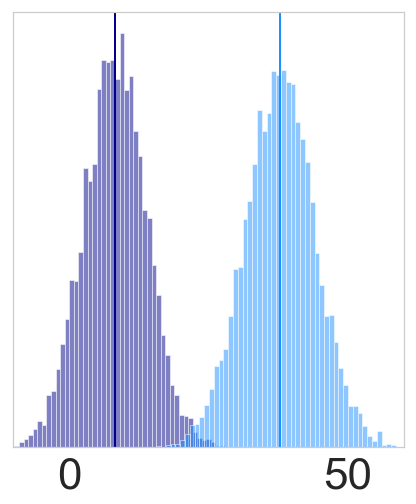

In [13]:
sns.set(style="whitegrid",font_scale=4)
plt.figure(figsize=(7, 8))
fig = plt.hist((hierarchical_linear_trace['a'][:,0]), bins=50, color="darkblue", alpha=0.5)
fig = plt.hist((hierarchical_linear_trace['a'][:,1]), bins=50, color="dodgerblue", alpha=0.5)

plt.grid(b=None)
#plt.axvline(x=0.0, color="black",lw=2,ls="--")
plt.axvline(x=8.18, color="darkblue",lw=2,ls="-")
plt.axvline(x=37.78, color="dodgerblue",lw=2,ls="-")
plt.xlim((-10, 60))
plt.yticks([])
plt.show()

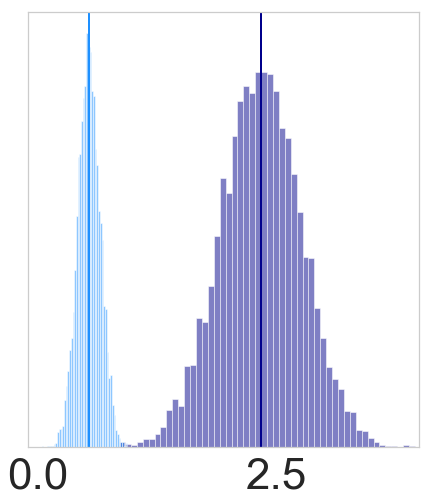

In [14]:
sns.set(style="whitegrid",font_scale=4)
plt.figure(figsize=(7, 8))
fig = plt.hist((hierarchical_linear_trace['b'][:,0]), bins=50, color="darkblue", alpha=0.5)
fig = plt.hist((hierarchical_linear_trace['b'][:,1]), bins=50, color="dodgerblue", alpha=0.5)

plt.grid(b=None)
#plt.axvline(x=0.0, color="black",lw=2,ls="--")
plt.axvline(x=2.34, color="darkblue",lw=2,ls="-")
plt.axvline(x=0.54, color="dodgerblue",lw=2,ls="-")
plt.xlim((-0.1, 4))
plt.yticks([])
plt.show()

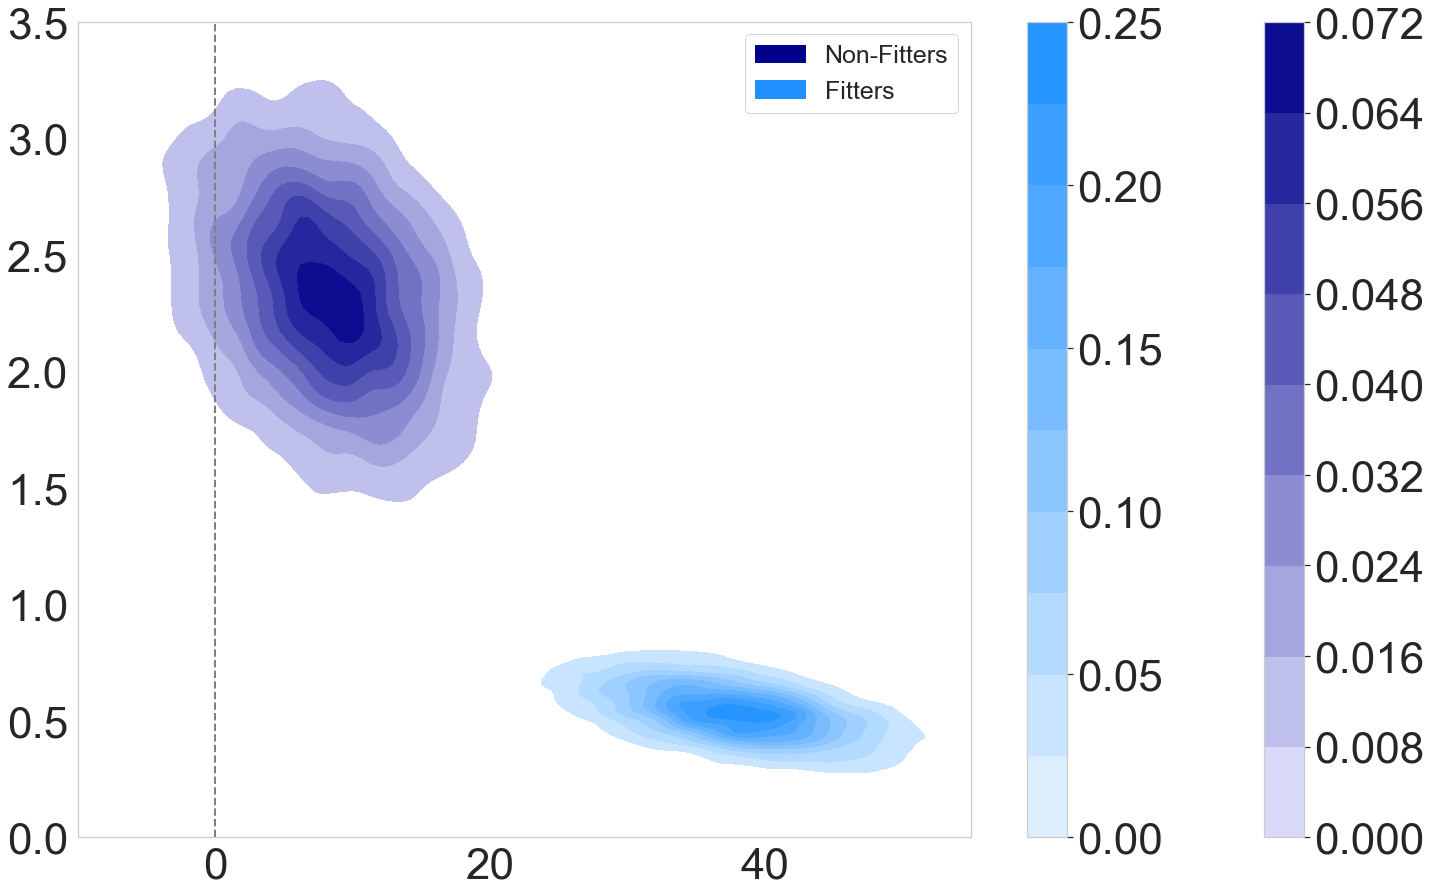

In [15]:
for i in [1]:
    plt.figure(figsize=(25,15))
    NMF_L = hierarchical_linear_trace['b'][:,0] 
    NMF_R = hierarchical_linear_trace['b'][:,1]

    sns.set(style="whitegrid",font_scale=4)

    sns.kdeplot(np.array(hierarchical_linear_trace['a'])[:,0], NMF_L, shade=True, color="darkblue", label="Non-Fitters", shade_lowest=False, cbar=True)
    sns.kdeplot(np.array(hierarchical_linear_trace['a'])[:,1], NMF_R, shade=True, color="dodgerblue", label="Fitters", shade_lowest=False, cbar=True)
    plt.axvline(x=0.0, color="grey",lw=2,ls="--")
    plt.grid(False)
    plt.xlim(-10,55)
    plt.ylim(0,3.5)
    plt.legend(fontsize=25, loc="upper right")
    plt.show()

In [7]:
# adding jitter
def rand_jitter(arr):
    stdev = .015*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

def jitter(x, y, s=150, c='b', marker='o', cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=1, verts=None, hold=None,edgecolors= "white", **kwargs):
    return plt.scatter(x, rand_jitter(y), s=s, marker=marker, cmap=cmap, norm=norm, vmin=vmin, vmax=vmax, alpha=alpha, linewidths=linewidths, verts=verts,edgecolors=edgecolors, **kwargs)

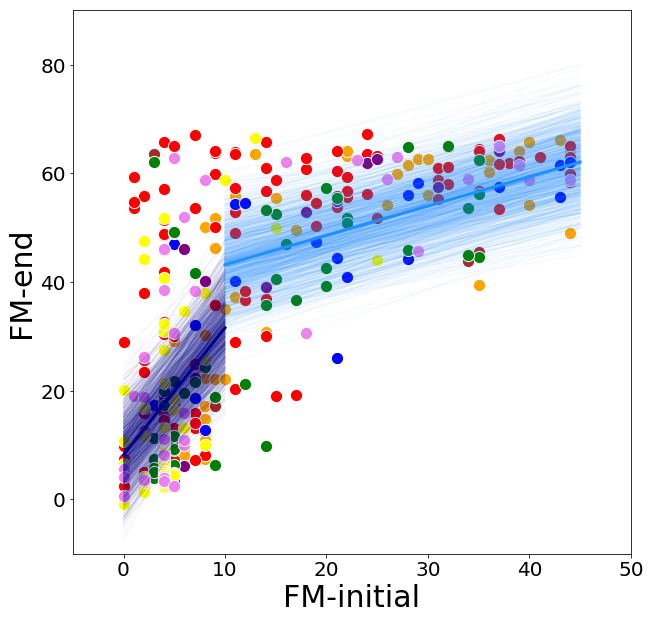

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

for n in np.random.permutation(2000)[0:1000]:
    x = [0,10]
    y = [np.array(hierarchical_linear_trace['a'])[n,0], np.array(hierarchical_linear_trace['a'])[n,0] + np.array(hierarchical_linear_trace['b'])[n,0]*10]
    plt.plot(x,y,color='darkblue', linewidth=1, alpha=0.05)
for n in np.random.permutation(2000)[0:1000]:
    x = [10,45]
    y = [np.array(hierarchical_linear_trace['a'])[n,1] + np.array(hierarchical_linear_trace['b'])[n,1]*10, np.array(hierarchical_linear_trace['a'])[n,1] + np.array(hierarchical_linear_trace['b'])[n,1]*45]
    plt.plot(x,y,color='dodgerblue', linewidth=1, alpha=0.05)
jitter(FM[FM["Study"]==1]["TP1"], FM[FM["Study"]==1]["TP2"], color="orange")
jitter(FM[FM["Study"]==3]["TP1"], FM[FM["Study"]==3]["TP2"], color="red")
jitter(FM[FM["Study"]==0]["TP1"], FM[FM["Study"]==0]["TP2"], color="blue")
jitter(FM[FM["Study"]==4]["TP1"], FM[FM["Study"]==4]["TP2"], color="purple")
jitter(FM[FM["Study"]==5]["TP1"], FM[FM["Study"]==5]["TP2"], color="brown")
jitter(FM[FM["Study"]==2]["TP1"], FM[FM["Study"]==2]["TP2"], color="green")
jitter(FM[FM["Study"]==6]["TP1"], FM[FM["Study"]==6]["TP2"], color="yellow")
jitter(FM[FM["Study"]==7]["TP1"], FM[FM["Study"]==7]["TP2"], color="violet")
ax.set_ylabel('FM-end', fontsize=30) 
ax.set_xlabel('FM-initial', fontsize=30) 
plt.tick_params(labelsize=20)
plt.xlim(-5,50)
plt.ylim(-10,90)
x = [0,10]
y = [8.18, (8.18+10*2.34)]
plt.plot(x,y,color='darkblue', linewidth=3)
x = [10,45]
y = [37.78+10*0.54, (37.78+45*0.54)]
plt.plot(x,y,color='dodgerblue', linewidth=3)

plt.show()

In [10]:
Y_ppc_insample = pm.sample_ppc(hierarchical_linear_trace, 2000, hierarchical_linear_model, random_seed=456)['FM_like']
y_pred_insample = Y_ppc_insample.mean(axis=0)
ppc_insample = r2_score(FM.TP2.values, y_pred_insample)
out_str = 'PPC in sample R^2: %2.6f' % (ppc_insample)
print(out_str)

/Users/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  """Entry point for launching an IPython kernel.
/Users/anna/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:02<00:00, 767.97it/s]

PPC in sample R^2: 0.617390


In [15]:
with pm.Model() as linear_model_45:
    
    mu_a = pm.Normal('mu_a', mu=0., sd=20)
    mu_b = pm.Normal('mu_b', mu=0., sd=5)
    mu_a2 = pm.Normal('mu_a2', mu=0., sd=5)
    sigma_a2 = pm.HalfCauchy('sigma_a2', 5)
    
    a2 = pm.Normal('a2', mu=mu_a2, sd=sigma_a2, shape=n_studies_2)

    # Model error
    eps = pm.HalfCauchy('eps', 20)

    FM_est = a2[study_idx_2] + mu_a + mu_b * FM.TP1

    # Data likelihood
    FM_like = pm.Normal('FM_like', mu=FM_est, sd=eps, observed=FM.TP2)

In [16]:
with linear_model_45:
    linear_trace_45 = pm.sample(draws=2000, n_init=1000, random_seed=456)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, a2, sigma_a2, mu_a2, mu_b, mu_a]
Sampling 4 chains, 2 divergences: 100%|██████████| 10000/10000 [00:17<00:00, 561.32draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


/Users/anna/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


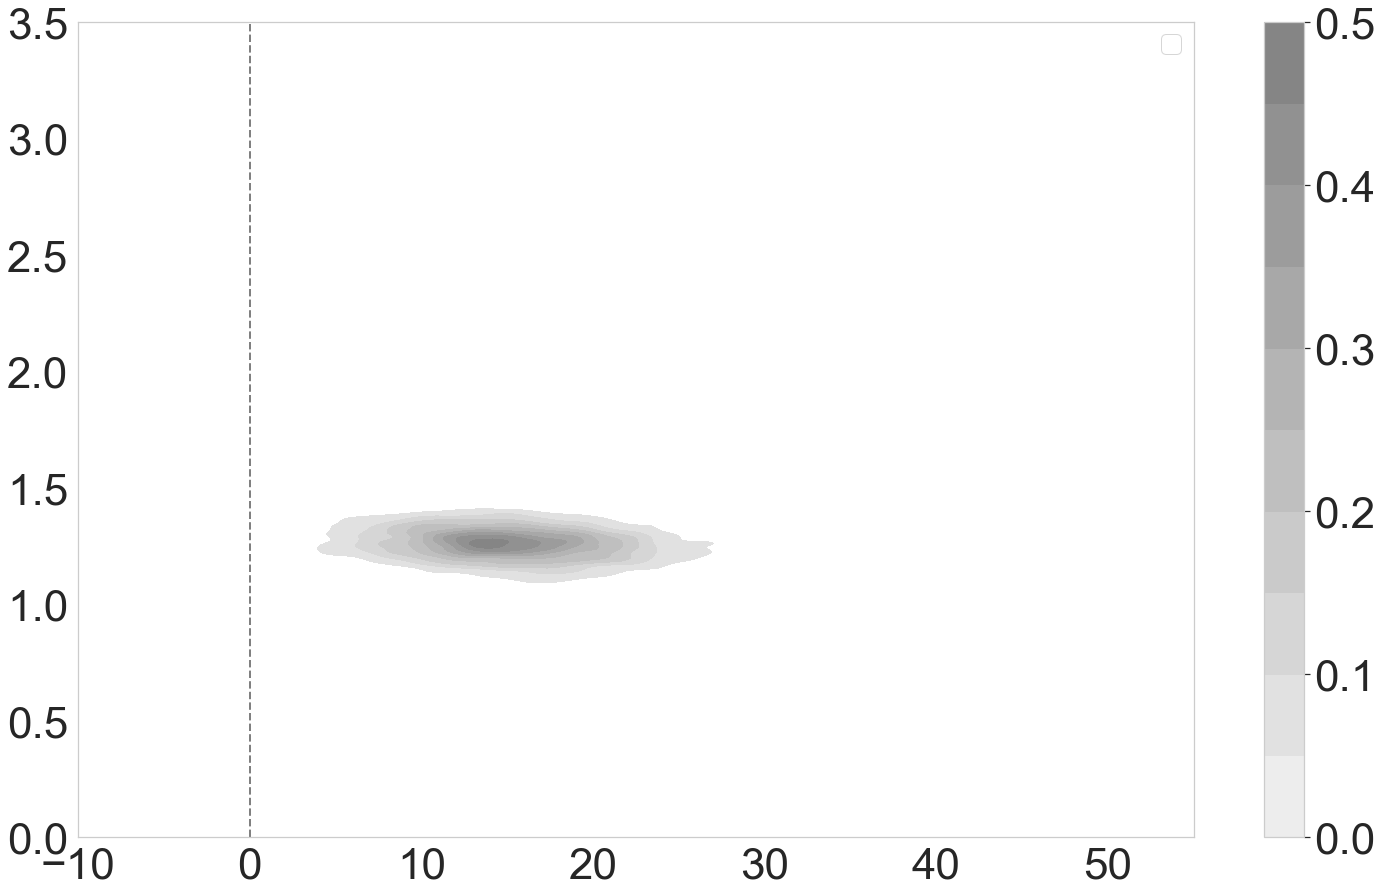

In [23]:
for i in [1]:
    plt.figure(figsize=(25,15))
    NMF_L = linear_trace_45['mu_b']

    sns.set(style="whitegrid",font_scale=4)
    sns.kdeplot(np.array(linear_trace_45['mu_a']), NMF_L, shade=True, color="grey", shade_lowest=False, cbar=True)
    plt.axvline(x=0.0, color="grey",lw=2,ls="--")
    plt.grid(False)
    plt.xlim(-10,55)
    plt.ylim(0,3.5)
    plt.legend(fontsize=25, loc="upper right")
    plt.show()

In [24]:
pm.summary(linear_trace_45).round(2)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,15.03,5.28,4.64,25.01,0.15,0.11,1239.0,1239.0,1241.0,1740.0,1.0
mu_b,1.26,0.07,1.13,1.40,0.00,0.00,4704.0,4697.0,4707.0,4242.0,1.0
mu_a2,0.95,4.86,-8.52,10.01,0.14,0.10,1273.0,1273.0,1274.0,1879.0,1.0
a2[0],0.60,5.61,-9.95,11.24,0.15,0.11,1395.0,1395.0,1396.0,2273.0,1.0
a2[1],1.47,5.44,-9.12,11.56,0.15,0.11,1270.0,1270.0,1270.0,2104.0,1.0
a2[2],-2.10,5.43,-12.77,8.14,0.15,0.11,1294.0,1294.0,1295.0,1905.0,1.0
a2[3],6.84,5.34,-3.09,17.09,0.15,0.10,1291.0,1291.0,1293.0,1778.0,1.0
a2[4],2.78,5.81,-8.11,13.59,0.15,0.11,1493.0,1493.0,1492.0,2534.0,1.0
a2[5],-0.05,5.74,-11.23,10.70,0.15,0.10,1517.0,1517.0,1521.0,2519.0,1.0
a2[6],-3.14,5.47,-13.73,7.07,0.15,0.11,1346.0,1346.0,1347.0,1975.0,1.0


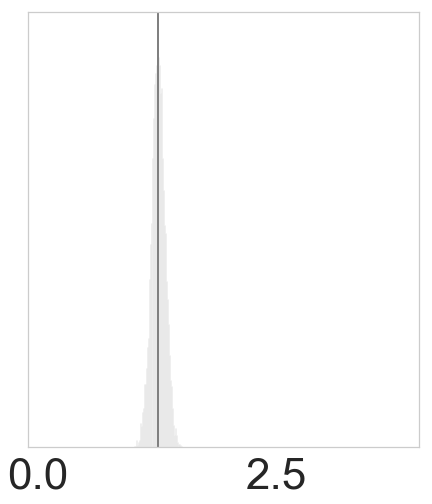

In [25]:
sns.set(style="whitegrid",font_scale=4)
plt.figure(figsize=(7, 8))
fig = plt.hist((linear_trace_45['mu_b']), bins=50, color="grey", alpha=0.5)

plt.grid(b=None)
plt.axvline(x=1.26, color="grey",lw=2,ls="-")
plt.xlim((-0.1, 4))
plt.yticks([])
plt.show()

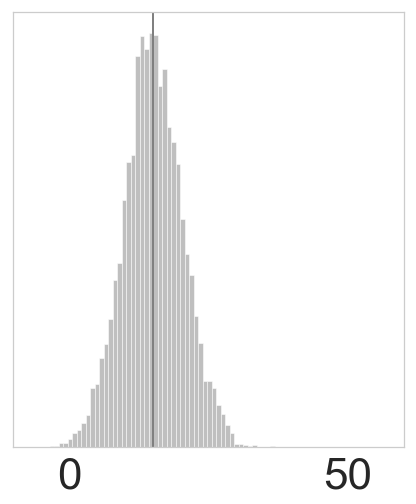

In [26]:
sns.set(style="whitegrid",font_scale=4)
plt.figure(figsize=(7, 8))
fig = plt.hist((linear_trace_45['mu_a']), bins=50, color="grey", alpha=0.5)

plt.grid(b=None)
plt.axvline(x=15.03, color="grey",lw=2,ls="-")
plt.xlim((-10, 60))
plt.yticks([])
plt.show()

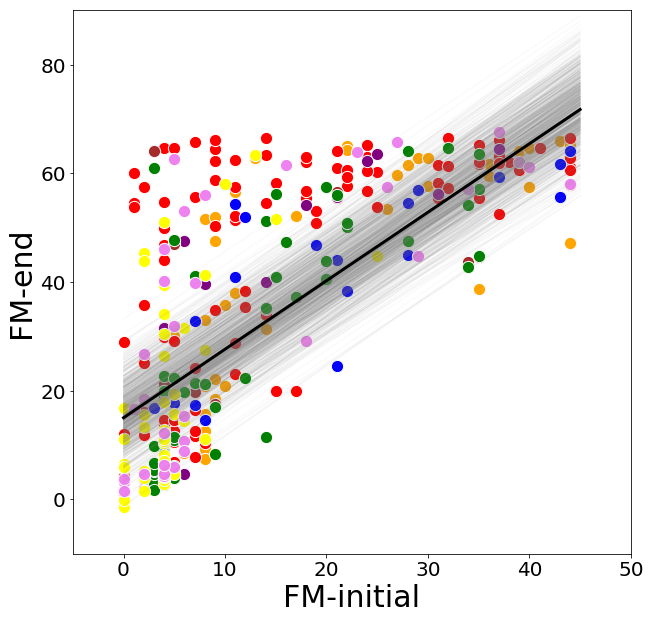

In [26]:
fig, ax = plt.subplots(figsize=(10, 10))

for n in np.random.permutation(2000)[0:1000]:
    x = [0,45]
    y = [linear_trace_45["mu_a"][n], linear_trace_45["mu_a"][n] + linear_trace_45["mu_b"][n]*45]
    plt.plot(x,y,color='grey', linewidth=1, alpha=0.05)
jitter(FM[FM["Study"]==1]["TP1"], FM[FM["Study"]==1]["TP2"], color="orange")
jitter(FM[FM["Study"]==3]["TP1"], FM[FM["Study"]==3]["TP2"], color="red")
jitter(FM[FM["Study"]==0]["TP1"], FM[FM["Study"]==0]["TP2"], color="blue")
jitter(FM[FM["Study"]==4]["TP1"], FM[FM["Study"]==4]["TP2"], color="purple")
jitter(FM[FM["Study"]==5]["TP1"], FM[FM["Study"]==5]["TP2"], color="brown")
jitter(FM[FM["Study"]==2]["TP1"], FM[FM["Study"]==2]["TP2"], color="green")
jitter(FM[FM["Study"]==6]["TP1"], FM[FM["Study"]==6]["TP2"], color="yellow")
jitter(FM[FM["Study"]==7]["TP1"], FM[FM["Study"]==7]["TP2"], color="violet")
ax.set_ylabel('FM-end', fontsize=30) 
ax.set_xlabel('FM-initial', fontsize=30) 
plt.tick_params(labelsize=20)
plt.xlim(-5,50)
plt.ylim(-10,90)
x = [0,45]
y = [15.03, (15.03+45*1.26)]
plt.plot(x,y,color='black', linewidth=3)
#plt.legend()

plt.show()

In [29]:
# check what's the correct y to compare to
Y_ppc_insample = pm.sample_ppc(linear_trace_45, 2000, linear_model_45, random_seed=456)['FM_like']
y_pred_insample = Y_ppc_insample.mean(axis=0)
ppc_insample = r2_score(FM.TP2, y_pred_insample)
out_str = 'PPC in sample R^2: %2.6f' % (ppc_insample)
print(out_str)

/Users/anna/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
/Users/anna/anaconda3/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
100%|██████████| 2000/2000 [00:03<00:00, 623.68it/s]

PPC in sample R^2: 0.549612


In [30]:
summary = pm.summary(linear_trace_45).round(2)
summary = pd.DataFrame(summary)
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,15.03,5.28,4.64,25.01,0.15,0.11,1239.0,1239.0,1241.0,1740.0,1.0
mu_b,1.26,0.07,1.13,1.40,0.00,0.00,4704.0,4697.0,4707.0,4242.0,1.0
mu_a2,0.95,4.86,-8.52,10.01,0.14,0.10,1273.0,1273.0,1274.0,1879.0,1.0
a2[0],0.60,5.61,-9.95,11.24,0.15,0.11,1395.0,1395.0,1396.0,2273.0,1.0
a2[1],1.47,5.44,-9.12,11.56,0.15,0.11,1270.0,1270.0,1270.0,2104.0,1.0
a2[2],-2.10,5.43,-12.77,8.14,0.15,0.11,1294.0,1294.0,1295.0,1905.0,1.0
a2[3],6.84,5.34,-3.09,17.09,0.15,0.10,1291.0,1291.0,1293.0,1778.0,1.0
a2[4],2.78,5.81,-8.11,13.59,0.15,0.11,1493.0,1493.0,1492.0,2534.0,1.0
a2[5],-0.05,5.74,-11.23,10.70,0.15,0.10,1517.0,1517.0,1521.0,2519.0,1.0
a2[6],-3.14,5.47,-13.73,7.07,0.15,0.11,1346.0,1346.0,1347.0,1975.0,1.0


In [31]:
hierarchical_linear_model.name = 'hierarchical_linear'
linear_model_45.name = 'linear'

df_comp_WAIC = pm.compare({hierarchical_linear_model: hierarchical_linear_trace, linear_model_45: linear_trace_45, })
df_comp_WAIC

/Users/anna/anaconda3/lib/python3.7/site-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
<pymc3.model.Model object at 0x11271b3c8>,0,2945.57,9.78429,0,0.999579,31.7854,0,True,deviance
<pymc3.model.Model object at 0x1c2dc6c748>,1,2999.07,7.10774,53.5066,0.000421476,24.5853,15.7424,False,deviance


/Users/anna/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '
/Users/anna/anaconda3/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '
/Users/anna/anaconda3/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained_layout not applied.  At least '
/Users/anna/anaconda3/lib/python3.7/site-packages/matplotlib/_constrained_layout.py:226: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  warnings.warn('constrained

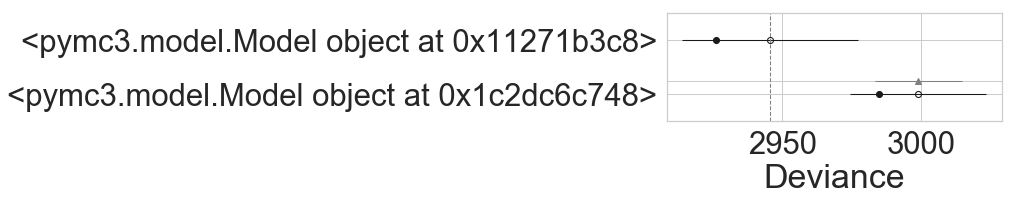

In [32]:
pm.compareplot(df_comp_WAIC)
plt.tight_layout()

In [35]:
df_comp_LOO = pm.compare({hierarchical_linear_model: hierarchical_linear_trace, linear_model_45: linear_trace_45, }, ic='LOO')
df_comp_LOO

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
<pymc3.model.Model object at 0x111bfd898>,0,2945.61,9.80425,0,0.998963,33.2249,0,False,deviance
<pymc3.model.Model object at 0x1c31c37828>,1,2999.1,7.12002,53.4912,0.00103653,24.5999,15.7445,False,deviance


/Users/anna/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


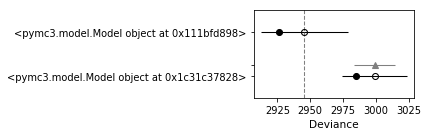

In [36]:
pm.compareplot(df_comp_LOO)
plt.tight_layout()
plt.show()

In [35]:
hierarchical_loo  = pm.loo(hierarchical_linear_trace, hierarchical_linear_model)
hierarchical_loo

Computed from 8000 by 359 log-likelihood matrix

       Estimate       SE
IC_loo  2945.61    32.40
p_loo      9.80        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      359  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%